In [ ]:
import pandas as  pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers,activations
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sb
from sklearn.model_selection import KFold,GroupKFold
from joblib import dump ,load
import os
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from pathlib import Path
import tensorboard

In [ ]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [ ]:
def features(data):
    
    data['time_passed'] = data.groupby('breath_id')['time_step'].diff(1)
    data['u_in_prev'] = data.groupby('breath_id')['u_in'].shift(1)
    data['u_in_prev_diff'] = data['u_in'] - data['u_in_prev']
    data['u_in_prev2'] = data.groupby('breath_id')['u_in'].shift(2)
    data['u_in_prev2_diff'] = data['u_in'] - data['u_in_prev2']
    data['u_in_cumsum'] = data.groupby('breath_id')['u_in'].cumsum()
    data['time_step_cumsum'] =  data.groupby('breath_id')['time_step'].cumsum()
    data['u_in_cumsum/time_cumsum'] =  data['u_in_cumsum'] /  data['time_step_cumsum']
    data['u_in_diff_time'] =   data['u_in_prev_diff'] / data['time_passed'] 
    data['u_out_prev'] = data.groupby('breath_id')['u_out'].shift(1)
    data['u_out_prev_diff'] = data['u_out'] - data['u_out_prev']
    data['u_out_diff_time'] =   data['u_out_prev_diff'] / data['time_passed']    
    data['prev_pressure'] = data.groupby('breath_id')['pressure'].shift(1)
    # data['pressure_diff'] = data.groupby('breath_id')['pressure'].diff(1) 
    # data['kmeans_val'] = pd.read_csv('kmeans.csv')
    data['R'] = data['R'].astype('str')
    data['C'] = data['C'].astype('str')
    data['R__C'] = data["R"].astype(str) + '__' + data["C"].astype(str)
    data = pd.get_dummies(data, drop_first=True) 
    data = data.replace(np.inf,-1)    
    data = data.fillna(0)
    return data

In [ ]:
def prepare_data(data):
    featured_data = features(data)
   
    prev_pressure = featured_data['prev_pressure'].to_numpy().reshape(-1,1)
    scaler = load('./drive/MyDrive/colab2/data_scaler.bin')
    scaled_data = scaler.transform(featured_data.drop(['pressure','prev_pressure','id','breath_id'],axis=1))#ScaleData(featured_data.drop(['pressure','prev_pressure','id','breath_id'],axis=1),save_scaler=True,save_path="data_scaler.bin")
    prev_scaler = load('./drive/MyDrive/colab2/prev_pressure_scaler.bin')
    prev_pressure_scaled = prev_scaler.transform(prev_pressure)
    print(scaled_data.shape)
    X = np.concatenate((scaled_data,prev_pressure_scaled),axis=1)
    Y = featured_data['pressure'].to_numpy()
    return X,Y
    

In [ ]:
def ScaleData(data,transform_only=False,save_scaler=False,save_path=None):
    scaler = preprocessing.RobustScaler()
    if transform_only:
        scaled_data = scaler.transform(data)
    else:
        scaled_data = scaler.fit_transform(data)
    
    if save_scaler:
        if save_path is None:
            raise "Path Not Defined"
        dump(scaler,save_path)
    
    return scaled_data

In [ ]:
def prepare_data(data):
    featured_data = features(data)
   
    prev_pressure = featured_data['prev_pressure'].to_numpy().reshape(-1,1)
    scaled_data = ScaleData(featured_data.drop(['pressure','prev_pressure','id','breath_id'],axis=1),save_scaler=True,save_path="data_scaler.bin")
    prev_pressure_scaled = ScaleData(prev_pressure,transform_only=False,save_scaler=True,save_path="prev_pressure_scaler.bin")
    print(scaled_data.shape)
    X = np.concatenate((scaled_data,prev_pressure_scaled),axis=1)
    Y = featured_data['pressure'].to_numpy()
    return X,Y
    

In [ ]:
data = pd.read_csv("train.csv")

In [ ]:
features(data)

,id,breath_id,time_step,u_in,u_out,pressure,time_passed,u_in_prev,u_in_prev_diff,u_in_prev2,u_in_prev2_diff,u_in_cumsum,time_step_cumsum,u_in_cumsum/time_cumsum,u_in_diff_time,u_out_prev,u_out_prev_diff,u_out_diff_time,prev_pressure,R_5,R_50,C_20,C_50,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50
0,1,1,0.000000,0.083334,0,5.837492,0.000000,0.000000,0.000000,0.000000,0.000000,0.083334,0.000000,-1.000000,0.000000,0.0,0.0,0.0,0.000000,0,0,0,1,0,1,0,0,0,0,0,0
1,2,1,0.033652,18.383041,0,5.907794,0.033652,0.083334,18.299707,0.000000,0.000000,18.466375,0.033652,548.740276,543.787629,0.0,0.0,0.0,5.837492,0,0,0,1,0,1,0,0,0,0,0,0
2,3,1,0.067514,22.509278,0,7.876254,0.033862,18.383041,4.126236,0.083334,22.425944,40.975653,0.101167,405.030935,121.854067,0.0,0.0,0.0,5.907794,0,0,0,1,0,1,0,0,0,0,0,0
3,4,1,0.101542,22.808822,0,11.742872,0.034028,22.509278,0.299544,18.383041,4.425781,63.784476,0.202709,314.660366,8.802930,0.0,0.0,0.0,7.876254,0,0,0,1,0,1,0,0,0,0,0,0
4,5,1,0.135756,25.355850,0,12.234987,0.034213,22.808822,2.547028,22.509278,2.846573,89.140326,0.338464,263.366841,74.445543,0.0,0.0,0.0,11.742872,0,0,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,2.504603,1.489714,1,3.869032,0.033412,1.420711,0.069002,1.353205,0.136509,387.109297,95.147046,4.068537,2.065221,1.0,0.0,0.0,3.939334,0,1,0,0,0,0,1,0,0,0,0,0
6035996,6035997,125749,2.537961,1.488497,1,3.869032,0.033358,1.489714,-0.001217,1.420711,0.067785,388.597794,97.685006,3.978070,-0.036476,1.0,0.0,0.0,3.869032,0,1,0,0,0,0,1,0,0,0,0,0
6035997,6035998,125749,2.571408,1.558978,1,3.798729,0.033447,1.488497,0.070481,1.489714,0.069264,390.156772,100.256414,3.891589,2.107258,1.0,0.0,0.0,3.869032,0,1,0,0,0,0,1,0,0,0,0,0
6035998,6035999,125749,2.604744,1.272663,1,4.079938,0.033337,1.558978,-0.286315,1.488497,-0.215834,391.429435,102.861158,3.805415,-8.588526,1.0,0.0,0.0,3.798729,0,1,0,0,0,0,1,0,0,0,0,0


In [ ]:
# train,test = train_test_split(data,test_size=0.3,shuffle=False,random_state=42)

In [ ]:
train_x,train_y = prepare_data(data.copy())

(6036000, 27)


In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,test_size=0.1,shuffle=False)

In [ ]:
groups = data['breath_id']

In [ ]:
FEATURES = train_x.shape[1]


In [ ]:
X_train = X_train.reshape(-1,1,FEATURES)
Y_train = Y_train.reshape(-1,1,1)


X_test = X_test.reshape(-1,1,FEATURES)
Y_test = Y_test.reshape(-1,1,1)

In [ ]:
X_train.shape,Y_train.shape

((5432400, 1, 28), (5432400, 1, 1))

In [ ]:
def Model():

   

    inputs = layers.Input(shape=(1,FEATURES))
    

    
    

    x = layers.Bidirectional(layers.LSTM(1024,return_sequences=True ))(inputs)
    x = layers.Bidirectional(layers.LSTM(512,return_sequences=True ))(x)
   
    x = layers.Bidirectional(layers.LSTM(256,return_sequences=True ))(x)
   
    x = layers.Bidirectional(layers.LSTM(128,return_sequences=True ))(x)


    
 
    
    x = layers.Dense(512,activation="selu")(x)
    x = layers.Dense(256,activation="selu")(x)
    
    x = layers.Dense(1)(x)
   
    
    return keras.Model(inputs=inputs,outputs=x)

In [ ]:
Model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 28)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 2048)          8626176   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 1024)          10489856  
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 512)           2623488   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 1, 256)           656384    
 nal)                                                        

In [ ]:
X = X_train
Y = Y_train

In [ ]:
KF = GroupKFold(n_splits=5)

In [ ]:
pred = []
hist = []
evals = []
histf =[]
evalf = []

In [ ]:
X.shape ,Y.shape

((6036000, 1, 28), (6036000, 1))

In [ ]:
FOLD = 1

In [ ]:



for train_index ,test_index in KF.split(X,Y,groups=groups):
    

  train_dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
  val_dataset = tf.data.Dataset.from_tensor_slices((X_test,Y_test))



  model = Model()
  opt= tf.keras.optimizers.Adam()


  model.compile(optimizer=opt,loss="mae",metrics=[tf.keras.metrics.MeanAbsolutePercentageError("mape_value"),tf.keras.metrics.MeanSquaredError("MSE value")])
  print(model.summary() )
      
  reduce_lr= tf.keras.callbacks.ReduceLROnPlateau(
  monitor="val_loss",
  factor=0.5,
  patience=2,
  verbose=1,
  mode="min",
  min_delta=0.0001,
  cooldown=0,
  min_lr=0,

  )


  early_stop = tf.keras.callbacks.EarlyStopping(
  monitor="val_loss",
  min_delta=0.001,
  patience=5,
  verbose=1,
  mode="min",
  baseline=None,
  restore_best_weights=True,
  )


  tensorboard_dir = "fit"
  tensorboard = tf.keras.callbacks.TensorBoard(
  log_dir=tensorboard_dir, write_graph=True, write_images=True,histogram_freq=1)







  checkpoint_filepath = f'model_FoldNo{FOLD}.h5'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_filepath,
  save_weights_only=False,
  monitor='val_loss',
  mode='min',
  save_best_only=True)
  print(f"------------------------------FoldNo{FOLD}------------------------------")


  


  BATCH_SIZE  = 80*50
  EPOCHS = 5

  train_dataset = train_dataset.batch(BATCH_SIZE)
  val_dataset = val_dataset.batch(80*20)


  history = model.fit(train_dataset,epochs=30,callbacks=[reduce_lr,model_checkpoint_callback,tensorboard])

        

    
    
    
    
    
    
    
    
    
    
    


  FOLD+=1

  

    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

In [ ]:
def predict(x,y,visualize=False,evaluate=False,index=None):
    results = []
    evaluations = []
    mapes = []
    for index in range(0,len(x)):
        result = model.predict(x[index].reshape(-1,1,FEATURES))
        results.append(result)
        mape = tf.keras.metrics.mean_absolute_percentage_error( y[index], result)
        mapes.append(mape)

        if evaluate:
            evaluation = model.evaluate(x[:index].reshape(1,-1,27),y[index])
    
    if visualize:
     
        mean_mape = round(np.mean(mapes),3)
        title = 'Real  vs Prediction - MAPE: %s' % round(mean_mape,2)
        print(np.mean(mapes),mean_mape)
        timesteps = np.arange(0,80)
        fig = plt.figure(figsize=(10,5))
        ax1 = fig.add_subplot()
        plt.title(title)
        ax1.scatter(timesteps,y,label='real')
        ax1.scatter(timesteps,results,label='predictions')
        plt.legend(loc='upper right');
        plt.xlabel('Timesteps')
        plt.ylabel('Pressure')
        plt.show()
        plt.savefig('Figure{0}.jpg'.format(index))
        

   
    return results

3.1263185 3.126


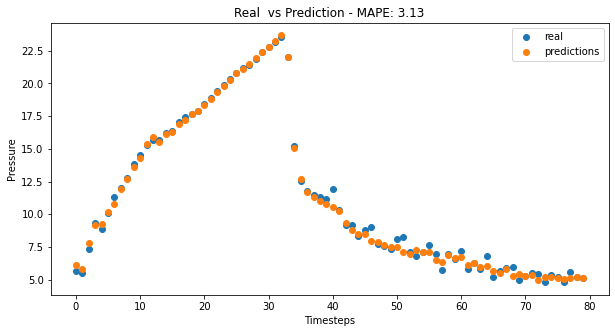

1.9243282 1.924


<Figure size 432x288 with 0 Axes>

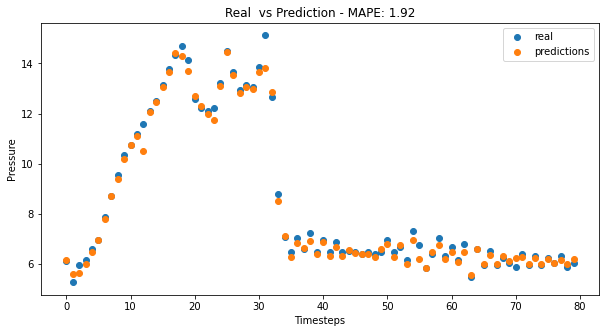

1.5336233 1.534


<Figure size 432x288 with 0 Axes>

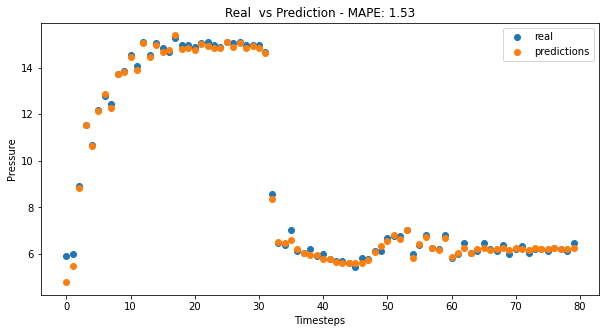

2.1203022 2.12


<Figure size 432x288 with 0 Axes>

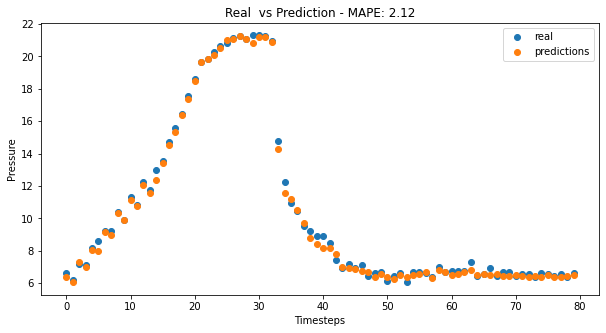

2.4799984 2.48


<Figure size 432x288 with 0 Axes>

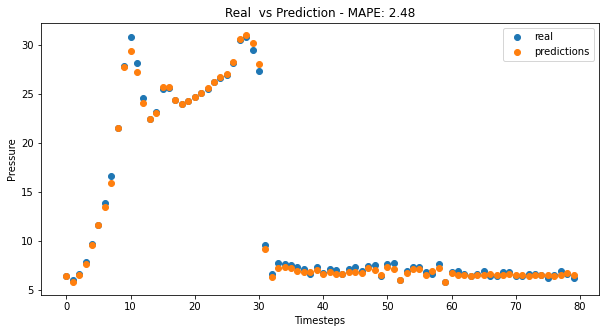

<Figure size 432x288 with 0 Axes>

In [ ]:
X_test = X_test.reshape(-1,80,1,FEATURES)
Y_test = Y_test.reshape(-1,80,1,1)
for i in range(5):
    random = np.random.randint(0,len(X_test))
    predict(X_test[random],Y_test[random],visualize=True,index=i)

<TakeDataset shapes: ((None, 1, 28), (None, 1, 1)), types: (tf.float64, tf.float64)>